In [ ]:
!pip install segmentation-models-pytorch --quiet
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from sklearn.metrics import accuracy_score
import time

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00


In [ ]:
# Install required packages (if not already installed)
!pip install torch torchvision torchaudio segmentation-models-pytorch albumentations --quiet

# Import libraries
import os
import cv2
import random
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pkdarabi/bone-fracture-detection-computer-vision-project")

print("Path to dataset files:", path)

100%|██████████| 84.1M/84.1M [00:00<00:00, 89.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2


In [ ]:
os.listdir(path)

['BoneFractureYolo8', 'bone fracture detection.v4-v4.yolov8']

In [ ]:
train_images = os.path.join(path, 'BoneFractureYolo8/train/images')
train_labels = os.path.join(path, 'BoneFractureYolo8/train/labels')
test_images = os.path.join(path, 'BoneFractureYolo8/test/images')
test_labels = os.path.join(path, 'BoneFractureYolo8/test/labels')
val_images = os.path.join(path, 'BoneFractureYolo8/valid/images')
val_labels = os.path.join(path, 'BoneFractureYolo8/valid/labels')

In [ ]:
class FractureDataset(Dataset):
    def __init__(self, image_dir, label_dir, task="classification", transform=None):
        """
        Dataset class for fracture classification and segmentation.

        Parameters:
        - image_dir (str): Path to the directory containing images.
        - label_dir (str): Path to the directory containing labels.
        - task (str): Either 'classification' or 'segmentation'.
        - transform: Transformations to apply to images.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.task = task  # Either "classification" or "segmentation"
        self.transform = transform

        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load label file
        label_name = image_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.label_dir, label_name)

        labels = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label_data = f.read().strip().split("\n")
                if label_data and label_data[0] != '':
                    labels = [[float(val) for val in line.split()] for line in label_data]

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]

        # **For Classification Task**
        if self.task == "classification":
            if not labels:
                class_label = torch.tensor(0, dtype=torch.long)  # No fracture class = 0
            else:
                class_label = torch.tensor(int(labels[0][0]), dtype=torch.long)  # First element is the class
            return image, class_label

        # **For Segmentation Task**
        elif self.task == "segmentation":
            # Initialize class_label here to handle cases where 'labels' is empty
            class_label = torch.tensor(0, dtype=torch.long)  # Default to No Fracture

            # Create segmentation_mask with requires_grad=True
            segmentation_mask = torch.zeros_like(image[0], dtype=torch.float32, requires_grad=False)

            if labels:
                class_label = torch.tensor(int(labels[0][0]), dtype=torch.long)  # First element is the class
                h, w = image.shape[1], image.shape[2]
                polygon_points = [[int(labels[0][i + 1] * w), int(labels[0][i + 2] * h)]  # x, y coordinates
                                for i in range(0, len(labels[0]) - 1, 2)]
                polygon_points = np.array(polygon_points, dtype=np.int32)

                cv2.fillPoly(segmentation_mask.cpu().detach().numpy(), [polygon_points], 1)

            # Return image, class label, and segmentation mask
            return image, class_label, segmentation_mask

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Transformation for classification (only applies to images)
classification_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Transformation for segmentation (applies to both images and masks)
segmentation_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [ ]:
train_dataset_cls = FractureDataset(
    image_dir=train_images, label_dir=train_labels,
    task="classification", transform=classification_transform
)

train_dataset_seg = FractureDataset(
    image_dir=train_images, label_dir=train_labels,
    task="segmentation", transform=segmentation_transform
)


In [ ]:
test_dataset_cls = FractureDataset(
    image_dir=test_images, label_dir=test_labels,
    task="classification", transform=classification_transform
)
test_dataset_seg = FractureDataset(
    image_dir=test_images, label_dir=test_labels,
    task="segmentation", transform=segmentation_transform
)

val_dataset_cls = FractureDataset(
    image_dir=val_images, label_dir=val_labels,
    task="classification", transform=classification_transform
)
val_dataset_seg = FractureDataset(
    image_dir=val_images, label_dir=val_labels,
    task="segmentation", transform=segmentation_transform
)

In [ ]:
from torch.utils.data import DataLoader

# Batch size (adjust based on GPU memory)
batch_size = 8

# Classification DataLoaders
train_loader_cls = DataLoader(train_dataset_cls, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=batch_size, shuffle=False, num_workers=0)

# Segmentation DataLoaders
train_loader_seg = DataLoader(train_dataset_seg, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_seg = DataLoader(val_dataset_seg, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_seg = DataLoader(test_dataset_seg, batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
import torchvision.models as models

class FractureClassifier(nn.Module):
  def __init__(self, num_classes=8):
      super(FractureClassifier, self).__init__()
      self.backbone = models.efficientnet_b1(pretrained=True)

      # Get the number of input features for the classifier
      in_features = self.backbone.classifier[1].in_features

      # Replace the last layer of the classifier
      self.backbone.classifier[1] = nn.Linear(in_features, num_classes)

  def forward(self, x):
      return self.backbone(x)

In [ ]:
class FractureSegmentation(nn.Module):
    def __init__(self, num_classes=7):  # No mask needed for class 0 (No Fracture)
        super(FractureSegmentation, self).__init__()
        self.unet = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=num_classes)

    def forward(self, x, class_label):
        mask_pred = self.unet(x)  # Shape: (batch_size, 7, H, W)

        # Extract the mask only for the predicted class
        batch_size, _, height, width = mask_pred.shape
        mask_out = torch.zeros((batch_size, 1, height, width), device=x.device)

        for i in range(batch_size):
            if class_label[i] > 0:  # Ignore No-Fracture class
                mask_out[i] = mask_pred[i, class_label[i] - 1].unsqueeze(0)

        return mask_out[:, 0] # Removing the unnecessary channel dimension

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Initialize models
classifier = FractureClassifier().to(device)
segmentation_model = FractureSegmentation().to(device)

# Define loss functions
classification_loss_fn = nn.CrossEntropyLoss()
segmentation_loss_fn = nn.BCEWithLogitsLoss()

# Define optimizers
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-4)
segmentation_optimizer = optim.Adam(segmentation_model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 88.5MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab sec

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
!pip install tqdm --quiet

from tqdm import tqdm

def train_classifier(model, train_loader, val_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        train_loss, correct, total = 0.0, 0, 0

        # Wrap the train_loader with tqdm to display progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                classifier_optimizer.zero_grad()

                outputs = model(images)
                loss = classification_loss_fn(outputs, labels)
                loss.backward()
                classifier_optimizer.step()

                train_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

                # Update the progress bar with metrics
                tepoch.set_postfix(loss=loss.item(), accuracy=(correct / total))

        train_acc = correct / total

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}")

# Train classifier first
train_classifier(classifier, train_loader_cls, val_loader_cls, epochs=5)

Epoch 1/5: 100%|██████████| 454/454 [22:08<00:00,  2.93s/batch, accuracy=0.654, loss=0.396]


Epoch 1/5, Train Loss: 0.9629, Train Acc: 0.6535


Epoch 2/5: 100%|██████████| 454/454 [22:08<00:00,  2.93s/batch, accuracy=0.829, loss=0.369]


Epoch 2/5, Train Loss: 0.4657, Train Acc: 0.8290


Epoch 3/5: 100%|██████████| 454/454 [22:08<00:00,  2.93s/batch, accuracy=0.913, loss=0.244]


Epoch 3/5, Train Loss: 0.2582, Train Acc: 0.9130


Epoch 4/5: 100%|██████████| 454/454 [22:02<00:00,  2.91s/batch, accuracy=0.957, loss=0.0465]


Epoch 4/5, Train Loss: 0.1401, Train Acc: 0.9568


Epoch 5/5: 100%|██████████| 454/454 [22:02<00:00,  2.91s/batch, accuracy=0.967, loss=0.15]

Epoch 5/5, Train Loss: 0.1017, Train Acc: 0.9672


In [ ]:
import torch

def dice_coefficient(pred, target, threshold=0.5, epsilon=1e-6):
    """
    Compute the Dice coefficient (F1-score for segmentation).
    """
    pred = (pred > threshold).float()  # Convert probabilities to binary (0 or 1)
    target = target.float()  # Ensure target is also a float

    # Modified to handle 3D tensors:
    intersection = (pred * target).sum(dim=(1, 2))  # Sum over dimensions 1 and 2 (height, width)
    union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2))

    dice = (2. * intersection + epsilon) / (union + epsilon)  # Avoid division by zero
    return dice.mean().item()  # Return average Dice score

def iou_coefficient(pred, target, threshold=0.5, epsilon=1e-6):
    """
    Compute the Intersection over Union (IoU) score.
    """
    pred = (pred > threshold).float()
    target = target.float()

    # Modified to handle 3D tensors:
    intersection = (pred * target).sum(dim=(1, 2))
    union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2)) - intersection

    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean().item()

In [ ]:
from tqdm import tqdm

def train_segmentation(model, train_loader, val_loader, epochs=10):
    model.train()

    for epoch in range(epochs):
        train_loss = 0.0
        dice_scores, iou_scores = [], []

        # Wrap the train_loader with tqdm for progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as tepoch:
            for images, class_labels, masks in tepoch: # Modified to unpack 3 values
                images, class_labels = images.to(device), class_labels.to(device)

                # Create a differentiable version of the mask
                masks_differentiable = masks.to(device).float()
                masks_differentiable.requires_grad = True

                segmentation_optimizer.zero_grad()

                outputs = model(images, class_labels) # Pass class_labels to the model
                loss = segmentation_loss_fn(outputs, masks_differentiable)
                loss.backward()
                segmentation_optimizer.step()

                train_loss += loss.item()

                # Compute Dice and IoU scores
                dice_score = dice_coefficient(outputs, masks)
                iou_score = iou_coefficient(outputs, masks)
                dice_scores.append(dice_score)
                iou_scores.append(iou_score)

                # Update progress bar
                tepoch.set_postfix(loss=loss.item(), dice=dice_score, iou=iou_score)

        # Compute average Dice and IoU scores
        avg_dice = sum(dice_scores) / len(dice_scores)
        avg_iou = sum(iou_scores) / len(iou_scores)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

In [ ]:
train_segmentation(segmentation_model, train_loader_seg, val_loader_seg, epochs=5)

Epoch 1/5 - Training: 100%|██████████| 454/454 [1:02:30<00:00,  8.26s/batch, dice=0.714, iou=0.714, loss=0.639]


Epoch 1/5 - Train Loss: 0.6039, Dice: 0.5091, IoU: 0.5065


Epoch 2/5 - Training: 100%|██████████| 454/454 [1:01:10<00:00,  8.09s/batch, dice=0.571, iou=0.571, loss=0.603]


Epoch 2/5 - Train Loss: 0.4822, Dice: 0.5046, IoU: 0.5040


Epoch 3/5 - Training: 100%|██████████| 454/454 [1:01:26<00:00,  8.12s/batch, dice=0.714, iou=0.714, loss=0.524]


Epoch 3/5 - Train Loss: 0.4509, Dice: 0.5168, IoU: 0.5127


Epoch 4/5 - Training: 100%|██████████| 454/454 [1:00:53<00:00,  8.05s/batch, dice=0.571, iou=0.571, loss=0.512]


Epoch 4/5 - Train Loss: 0.4390, Dice: 0.5330, IoU: 0.5244


Epoch 5/5 - Training: 100%|██████████| 454/454 [1:00:42<00:00,  8.02s/batch, dice=0.571, iou=0.571, loss=0.414]

Epoch 5/5 - Train Loss: 0.4314, Dice: 0.5526, IoU: 0.5403


In [ ]:
from tqdm import tqdm

def test_classifier(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing Classifier"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Classification Test Accuracy: {accuracy:.4f}")
    return all_preds, all_labels

# Run classification testing
classification_preds, classification_labels = test_classifier(classifier, test_loader_cls)


Testing Classifier: 100%|██████████| 22/22 [00:25<00:00,  1.18s/it]

Classification Test Accuracy: 0.6864


In [ ]:
def test_segmentation(model, test_loader):
    model.eval()
    dice_scores, iou_scores = [], []

    with torch.no_grad():
        for images, class_labels, masks in tqdm(test_loader, desc="Testing Segmentation"):
            images, class_labels, masks = images.to(device), class_labels.to(device), masks.to(device)
            predictions = model(images, class_labels)

            # Compute Dice and IoU scores
            dice = dice_coefficient(predictions, masks)
            iou = iou_coefficient(predictions, masks)

            dice_scores.append(dice)
            iou_scores.append(iou)

    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_iou = sum(iou_scores) / len(iou_scores)
    print(f"Segmentation Test - Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

# Run segmentation testing
test_segmentation(segmentation_model, test_loader_seg)


Testing Segmentation: 100%|██████████| 22/22 [00:53<00:00,  2.42s/it]

Segmentation Test - Dice: 0.5105, IoU: 0.5037


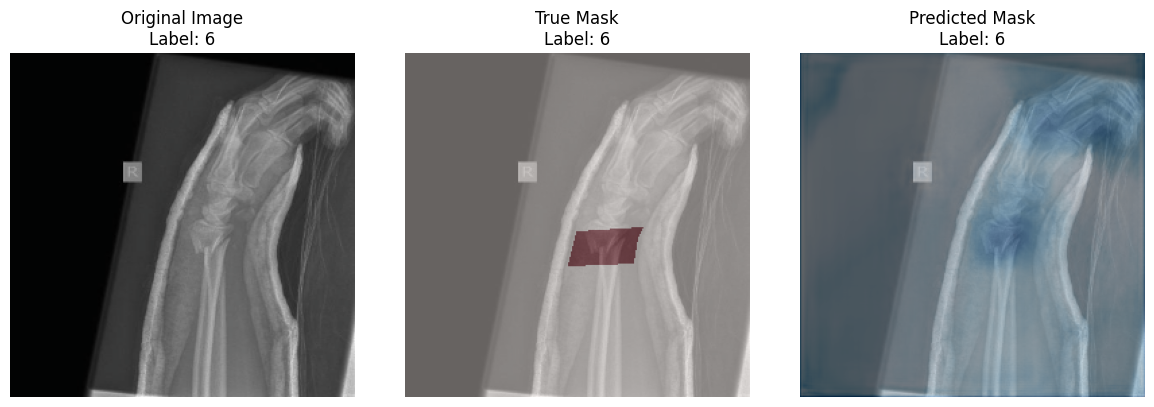

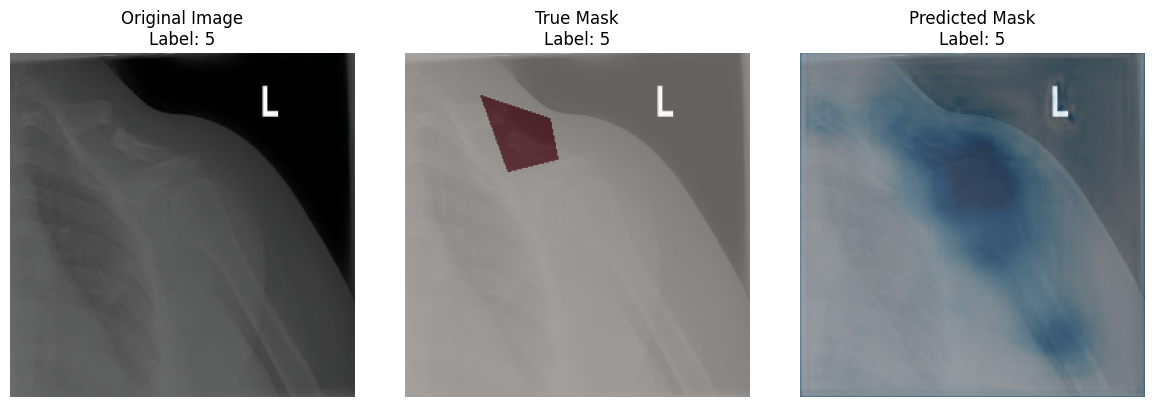

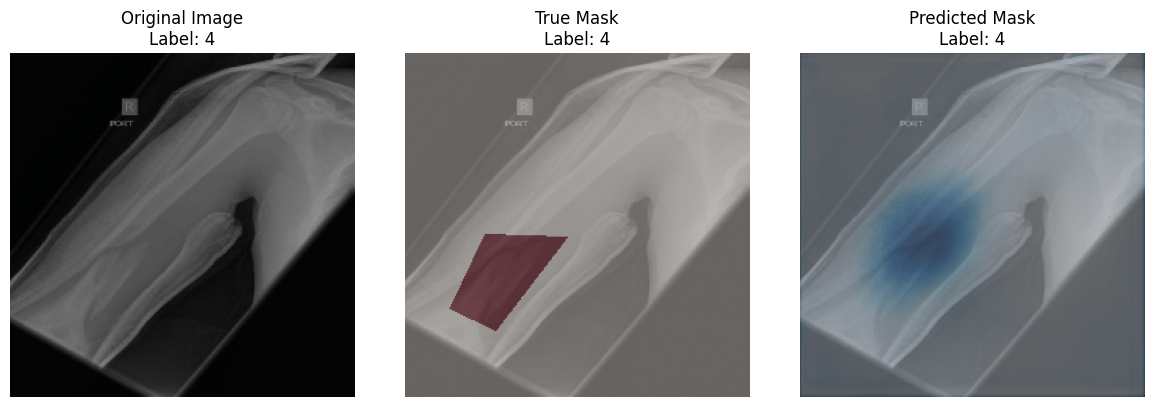

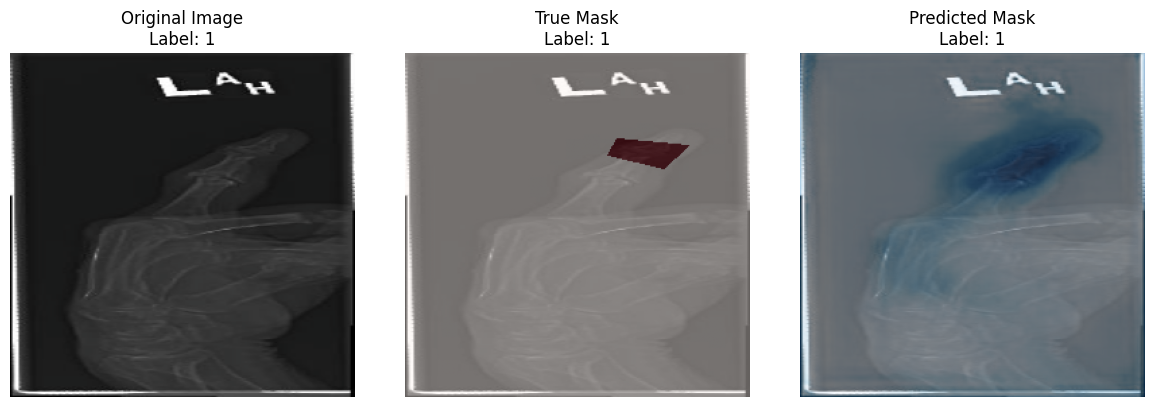

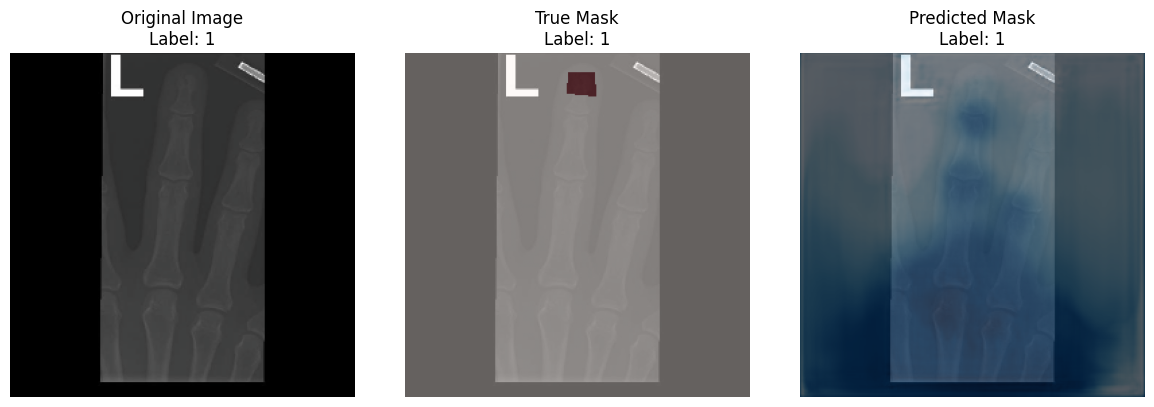

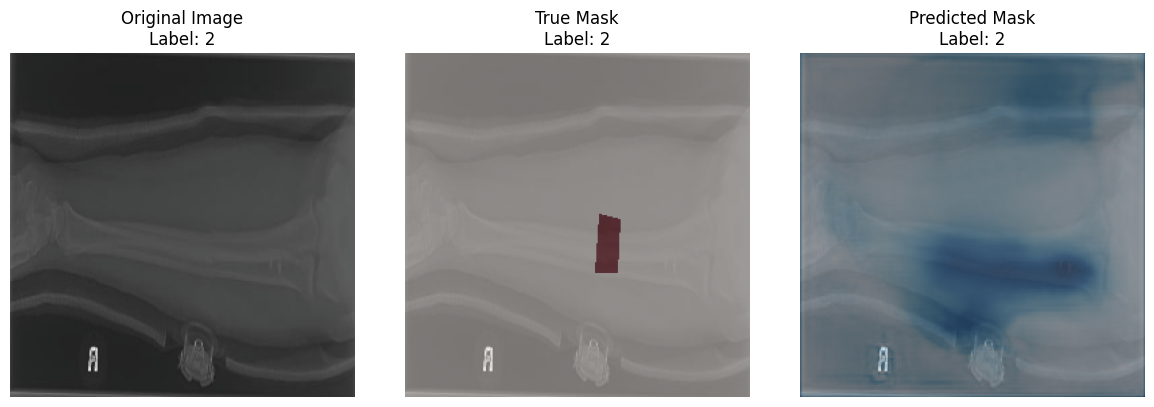

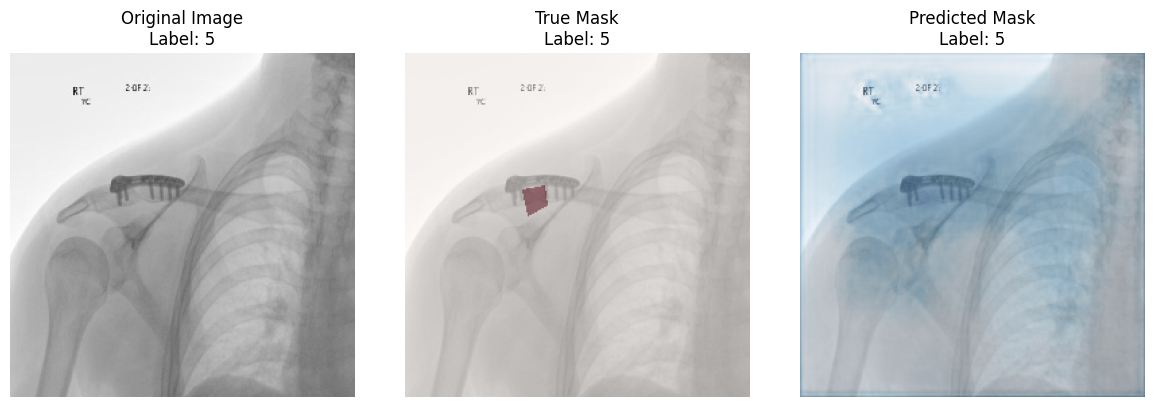

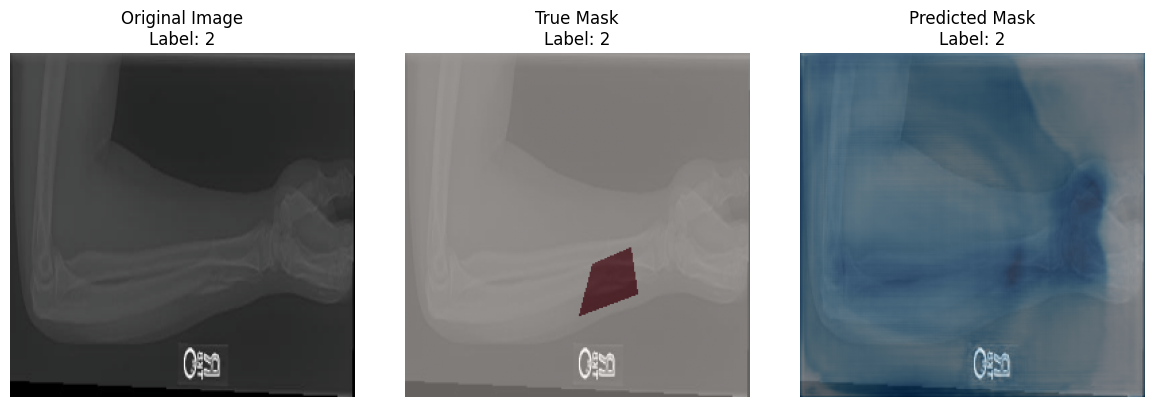

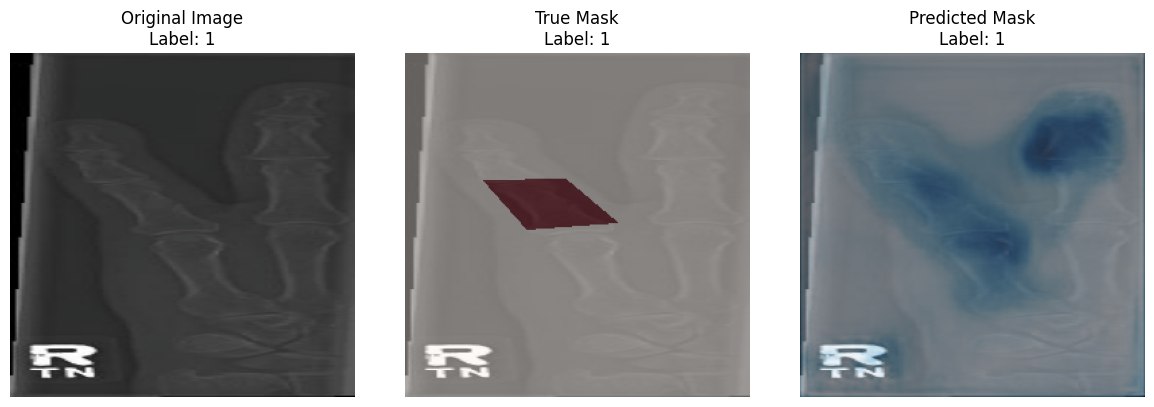

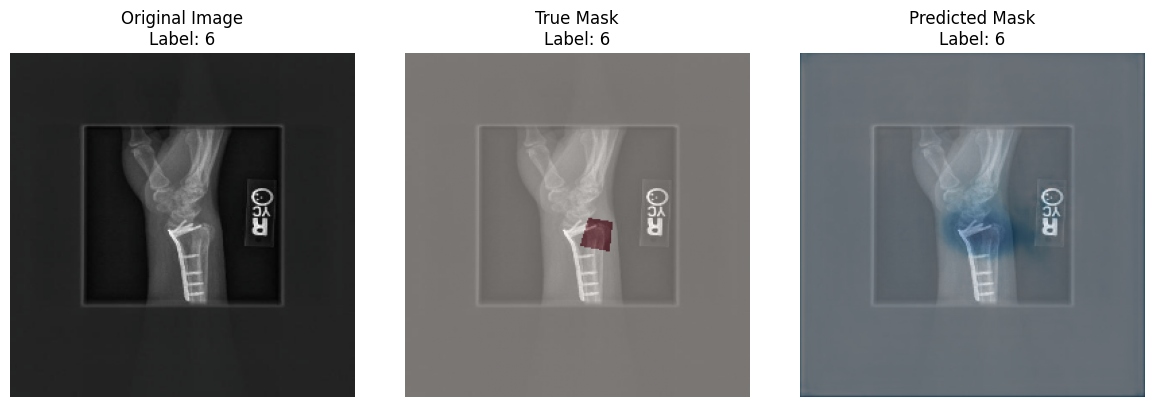

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming you normalized with these (adjust if yours are different)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def denormalize(img_tensor):
    """Denormalize image tensor using mean and std."""
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img = img * std + mean
    img = img.clip(0, 1)
    return img

def visualize_results(model, test_loader, num_samples=10):
    model.eval()
    shown_samples = 0

    with torch.no_grad():
        for images, class_labels, masks in test_loader:
            images, class_labels, masks = images.to(device), class_labels.to(device), masks.to(device)
            predictions = model(images, class_labels)

            for j in range(len(images)):
                label = class_labels[j].item()

                if label == 0:
                    continue  # Skip if no fracture

                if shown_samples >= num_samples:
                    return

                denorm_img = denormalize(images[j])
                true_mask = masks[j].cpu().numpy()
                pred_mask = predictions[j].cpu().numpy()

                plt.figure(figsize=(12, 4))

                # Original Image
                plt.subplot(1, 3, 1)
                plt.imshow(denorm_img)
                plt.title(f"Original Image\nLabel: {label}")
                plt.axis("off")

                # True Mask Overlay
                plt.subplot(1, 3, 2)
                plt.imshow(denorm_img)
                plt.imshow(true_mask, cmap="Reds", alpha=0.4)  # Red overlay for true mask
                plt.title(f"True Mask\nLabel: {label}")
                plt.axis("off")

                # Predicted Mask Overlay
                plt.subplot(1, 3, 3)
                plt.imshow(denorm_img)
                plt.imshow(pred_mask, cmap="Blues", alpha=0.4)  # Blue overlay for prediction
                plt.title(f"Predicted Mask\nLabel: {label}")
                plt.axis("off")

                plt.tight_layout()
                plt.show()

                shown_samples += 1

# Run visualization
visualize_results(segmentation_model, test_loader_seg)


In [ ]:
# Save classifier model
torch.save(classifier.state_dict(), 'classifier_model.pth')

# Save segmentation model
torch.save(segmentation_model.state_dict(), 'segmentation_model.pth')


In [ ]:
from google.colab import files

# Download classifier model
files.download('classifier_model.pth')

# Download segmentation model
files.download('segmentation_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>